In [ ]:
%load_ext autoreload
%autoreload 2
# Python base libraries
import gc
import random
# Main libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from tqdm import tqdm_notebook
# Deep Learning libraries
import keras
import keras.backend as K
from keras.initializers import Constant as C
from keras.layers import Conv2D, Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.utils.layer_utils import count_params
from livelossplot.keras import PlotLossesCallback
# Local libraries
from models.densenet import DenseNetFCN
from utils.dataset import *
from utils.gpu import reserve_gpus

In [2]:
GPU = 2
ids = reserve_gpus(GPU)
print(f"{len(ids)} GPUs allocated!")
print(f"Allocating GPUs: {','.join(map(str, ids))}")

2 GPUs allocated!
Allocating GPUs: 0,1


In [3]:
# SETTING VARIABLES
dataset_path = "../tfm_keras/dataset"
dataset_path_test = "../tfm_keras/dataset_test"
dataset_path_val = "../tfm_keras/dataset_val"

# Types of images to use
image_types = ["RAW", "FORCE"] # Not using FRET images
# If cropping is enable the cells will be cropped around the bounding boxes
crop = True
# Crops of size crop_size x crop_size will be made
crop_size = 256
# A margin around the bounding box of the cell will be allowed for extracting the crops
margin_size = int(crop_size * 0.5)
# Tukey window mask will be applied to the force to reduce high intensity border artefacts
tukey_p = 0.1 # 10%

In [4]:
%%time
print("Loading training cells...")
X, y = import_cells(dataset_path, crop, crop_size, margin_size, tukey_p, image_types)
print(f"{len(y)} frames loaded!")
print()

print("Loading testing cells...")
X_test, y_test = import_cells(dataset_path_test, crop, crop_size, margin_size, tukey_p, image_types)
print(f"{len(y_test)} frames loaded!")
print()

Loading training cells...
* 20160809-002-xy1
* 20160809-002-xy2
* 20160809-002-xy3
* 20160809-002-xy4
* 20160809-002-xy5
* 20160809-002-xy6
* 20160809-003-xy1
* 20160809-003-xy2
* 20160809-003-xy3
* 20160809-003-xy4
* 20160809-003-xy5
* 20160809-003-xy6
2158 frames loaded!

Loading testing cells...
* 20160810-001-xy1
* 20160810-001-xy2
* 20160810-001-xy3
* 20160810-001-xy4
* 20160810-001-xy5
* 20160810-001-xy6
* 20160810-002-xy1
* 20160810-002-xy2
* 20160810-002-xy3
* 20160810-002-xy4
* 20160810-002-xy5
1991 frames loaded!

CPU times: user 14.1 s, sys: 6.22 s, total: 20.3 s
Wall time: 20.3 s


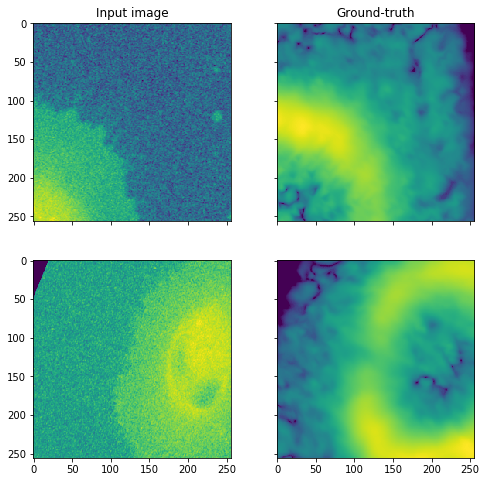

In [5]:
random.seed(0)
batch_size = 2
generator = generate_log_batch_augmented(X, y, batch_size, crop_size)
batch_X, batch_y = next(generator)

fig, ax = plt.subplots(batch_size, 2, figsize=(8, 4*batch_size), sharex=True, sharey=True)
for i in range(batch_size):
    if i == 0:
        ax[i, 0].set_title("Input image")
        ax[i, 1].set_title("Ground-truth")
    ax[i, 0].imshow(batch_X[i,:,:,0])
    ax[i, 1].imshow(batch_y[i,:,:,0])
plt.show()

In [6]:
nb_classes = 1
densenet = DenseNetFCN(
    input_shape = (None, None, nb_classes),
    nb_dense_block = 6, # default: 5
    growth_rate = 16, # default: 16
    nb_layers_per_block = 5, # default: 4
    reduction = 0.0, # default: 0.0
    dropout_rate = 0.2, # default: 0.0
    weight_decay = 1e-4, # default: 1e-4
    init_conv_filters = 48, # default: 48
    include_top = False, # default: True
    classes = nb_classes, # default: 1
    upsampling_conv = 128, # default: 128
    upsampling_type = "upsampling", # default: 'deconv', avail.: ['deconv', 'upsampling', 'subpixel']
    early_transition = False, # default: False
    transition_pooling = "max", # default: 'max', avail.: ['avg', 'max']
    initial_kernel_size = (3, 3), # default: (3, 3)
)

# Model top
last = densenet.output
# Output
pred_mean = Conv2D(
    filters=nb_classes,
    kernel_size=(1, 1),
    padding="same",
    activation="linear",
)(last)
pred_stddev = Conv2D(
    filters=nb_classes,
    kernel_size=(1, 1),
    padding="same",
    activation="softplus",
    kernel_initializer=C(0),
    bias_initializer=C(np.log(np.e-1))
)(last)
predictions = Concatenate()([pred_mean, pred_stddev])
model_ = Model(densenet.input, predictions)

if GPU == 1:
    model = model_
else:
    model = keras.utils.multi_gpu_model(
        model_,
        gpus=GPU,
        cpu_merge=True,
        cpu_relocation=False
    )

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
%%time
seed = 0 # Random seed

# Setting the default weights of the neural network
count = 0
session = K.get_session()
for layer in tqdm_notebook(model_.layers):
    if hasattr(layer, "kernel_initializer"):
        if isinstance(layer.kernel_initializer, keras.initializers.VarianceScaling):
            layer.kernel_initializer = keras.initializers.glorot_normal(seed)
        layer.kernel_initializer.run(session=session)
        count += 1
    if hasattr(layer, "bias_initializer"):
        layer.bias_initializer.run(session=session)
print(f"{count} layer weights reset.")

AttributeError: 'VarianceScaling' object has no attribute 'run'

In [11]:
def mse_loss():
    def mse_loss_(y_true, y_pred):
        pred_mu = y_pred[..., 0:1]
        pred_var = K.square(y_pred[..., 1:2])
        loss = K.square(y_true - pred_mu)
        return 0.5 * K.mean(loss / pred_var + K.log(pred_var))
    return mse_loss_

def mae_var(y_true, y_pred):
    pred_E = y_pred[..., 0:1]
    pred_V = K.square(y_pred[..., 1:2])
    pred = pred_E + 0.5 * pred_V
    return K.mean(K.abs(K.exp(y_true) - pred), axis=-1)

def mse_var(y_true, y_pred):
    pred_E = y_pred[..., 0:1]
    pred_V = K.square(y_pred[..., 1:2])
    pred = pred_E + 0.5 * pred_V
    return K.mean(K.square(y_true - pred))

model.compile(
    optimizer=Adam(clipnorm=1.0),
    loss=mse_loss(),
    metrics=[ mae_var, mse_var ]
)
trainable_count = count_params(model.trainable_weights)
print('Parameters to train:', trainable_count)

Parameters to train: 4324946


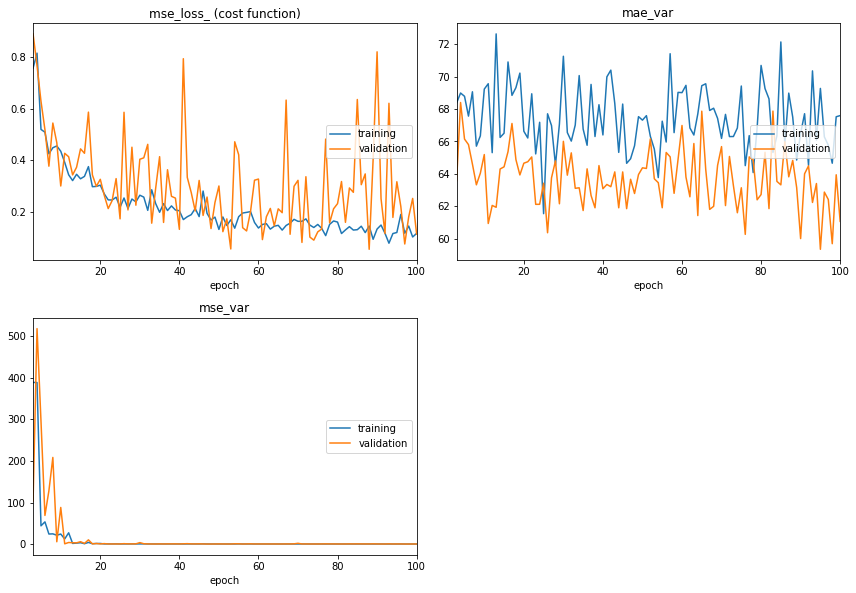

mse_loss_ (cost function):
training   (min:    0.077, max:   11.379, cur:    0.115)
validation (min:    0.053, max:    3.044, cur:    0.112)

mae_var:
training   (min:   61.549, max:   72.630, cur:   67.594)
validation (min:   59.352, max:  156.130, cur:   61.073)

mse_var:
training   (min:    0.456, max: 4488.572, cur:    0.491)
validation (min:    0.451, max: 118062.539, cur:    0.511)
CPU times: user 1h 46min 23s, sys: 12min 21s, total: 1h 58min 44s
Wall time: 51min 21s


In [12]:
%%time
batch_size = 8
history = model.fit_generator(
    generator=generate_log_batch_augmented(X, y, batch_size, crop_size),
    steps_per_epoch=50,
    epochs=100,
    validation_data=generate_log_batch_augmented(X_test, y_test, batch_size, crop_size),
    validation_steps=32,
    workers=1,
    use_multiprocessing=False,
    callbacks=[PlotLossesCallback()]
)

In [15]:
%%time
model_.save('results/result_densenet.h5')

CPU times: user 1min 2s, sys: 172 ms, total: 1min 3s
Wall time: 1min 3s


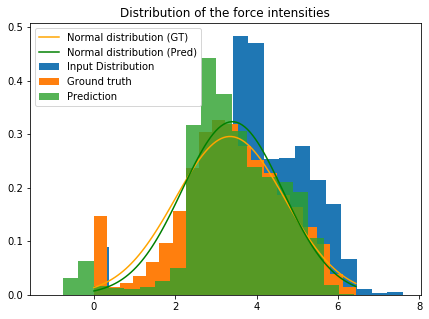

In [18]:
batch_size = 16
batch_X, batch_y = next(generate_log_batch_augmented(X_test, y_test, batch_size, crop_size))
y_pred = model.predict(batch_X)
y_pred_flat = (y_pred[..., 0]).ravel()
batch_y_flat = batch_y.flatten()

bins = 20
t = np.linspace(0, max(batch_y_flat.max(), y_pred_flat.max()), 100)

plt.figure(figsize=(7, 5))
plt.title('Distribution of the force intensities')
plt.hist(batch_X.flatten(), bins, density=True, label='Input Distribution')
plt.hist(batch_y_flat, bins, density=True, label='Ground truth')
plt.plot(t, st.norm.pdf(t, batch_y_flat.mean(), batch_y_flat.std()), 'orange', label='Normal distribution (GT)')
plt.hist(y_pred_flat, bins, alpha=0.8, density=True, label='Prediction')
plt.plot(t, st.norm.pdf(t, y_pred_flat.mean(), y_pred_flat.std()), 'green', label='Normal distribution (Pred)')

plt.legend()
plt.show()

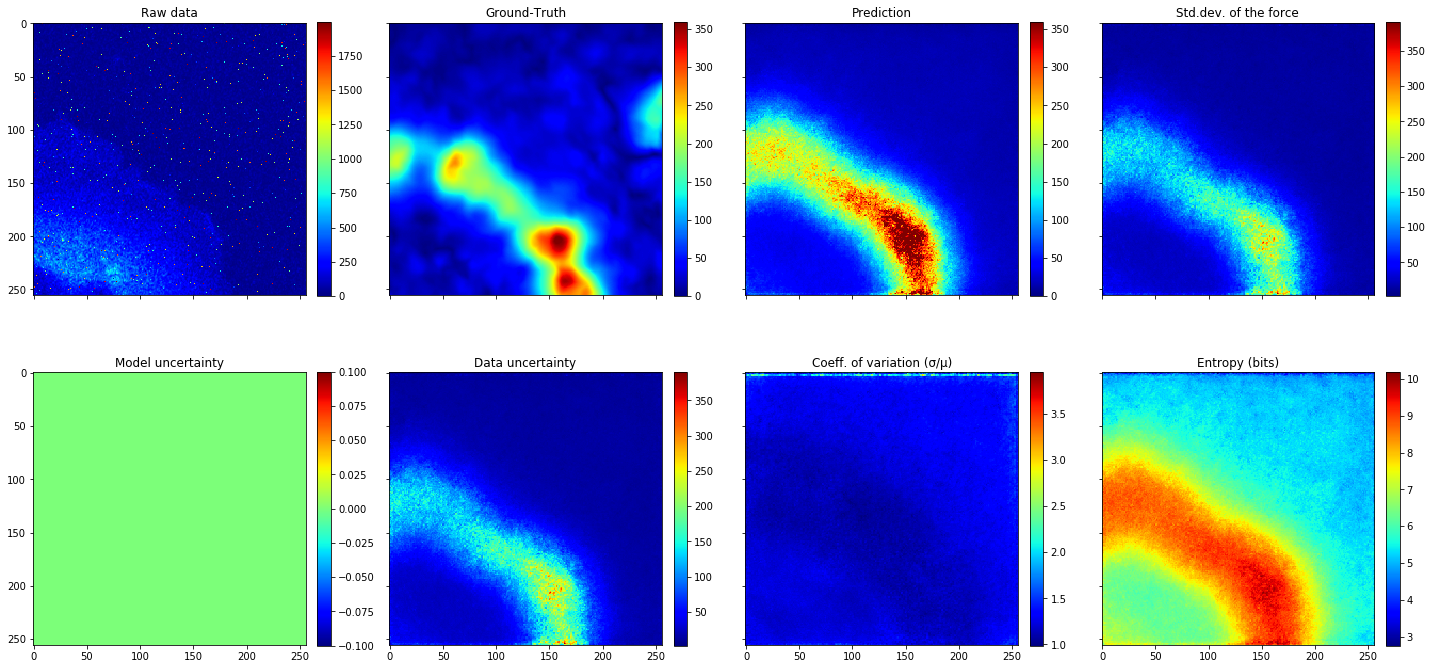

In [20]:
i = 0
visualize_cell(batch_X[i], batch_y[i], y_pred[i:i+1], figsize=(20, 10))
plt.show()

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>